사용 디바이스: cuda
그리드 서치 범위:
  hidden_size: [384, 512, 640, 768, 896]
  num_layers: [6, 7, 8]
  dropout: [0.1]
  batch_size: [64, 128, 192, 256, 320]
총 조합 수: 75
데이터셋 로딩 중...
훈련 데이터셋: 8000개
데이터 정규화 적용됨
테스트 데이터셋: 2000개
데이터 정규화 적용됨
총 75개의 조합을 테스트합니다.

[1/75] 테스트 중...
Hidden Size: 384, Layers: 6, Dropout: 0.1, Batch Size: 64
✓ 완료 - Test Loss: 0.155902, 시간: 44.4초
  모델 저장: model_h384_l6_d0.1_b64.pth
진행률: 1.3% | 예상 남은 시간: 54.8분

[2/75] 테스트 중...
Hidden Size: 384, Layers: 6, Dropout: 0.1, Batch Size: 128
✓ 완료 - Test Loss: 0.150133, 시간: 22.3초
  모델 저장: model_h384_l6_d0.1_b128.pth
진행률: 2.7% | 예상 남은 시간: 40.6분

[3/75] 테스트 중...
Hidden Size: 384, Layers: 6, Dropout: 0.1, Batch Size: 192
✓ 완료 - Test Loss: 0.145670, 시간: 16.9초
  모델 저장: model_h384_l6_d0.1_b192.pth
진행률: 4.0% | 예상 남은 시간: 33.5분

[4/75] 테스트 중...
Hidden Size: 384, Layers: 6, Dropout: 0.1, Batch Size: 256
✓ 완료 - Test Loss: 0.130025, 시간: 14.6초
  모델 저장: model_h384_l6_d0.1_b256.pth
진행률: 5.3% | 예상 남은 시간: 29.1분

[5/75] 테스트 중...
Hidden Size: 384, Layers:

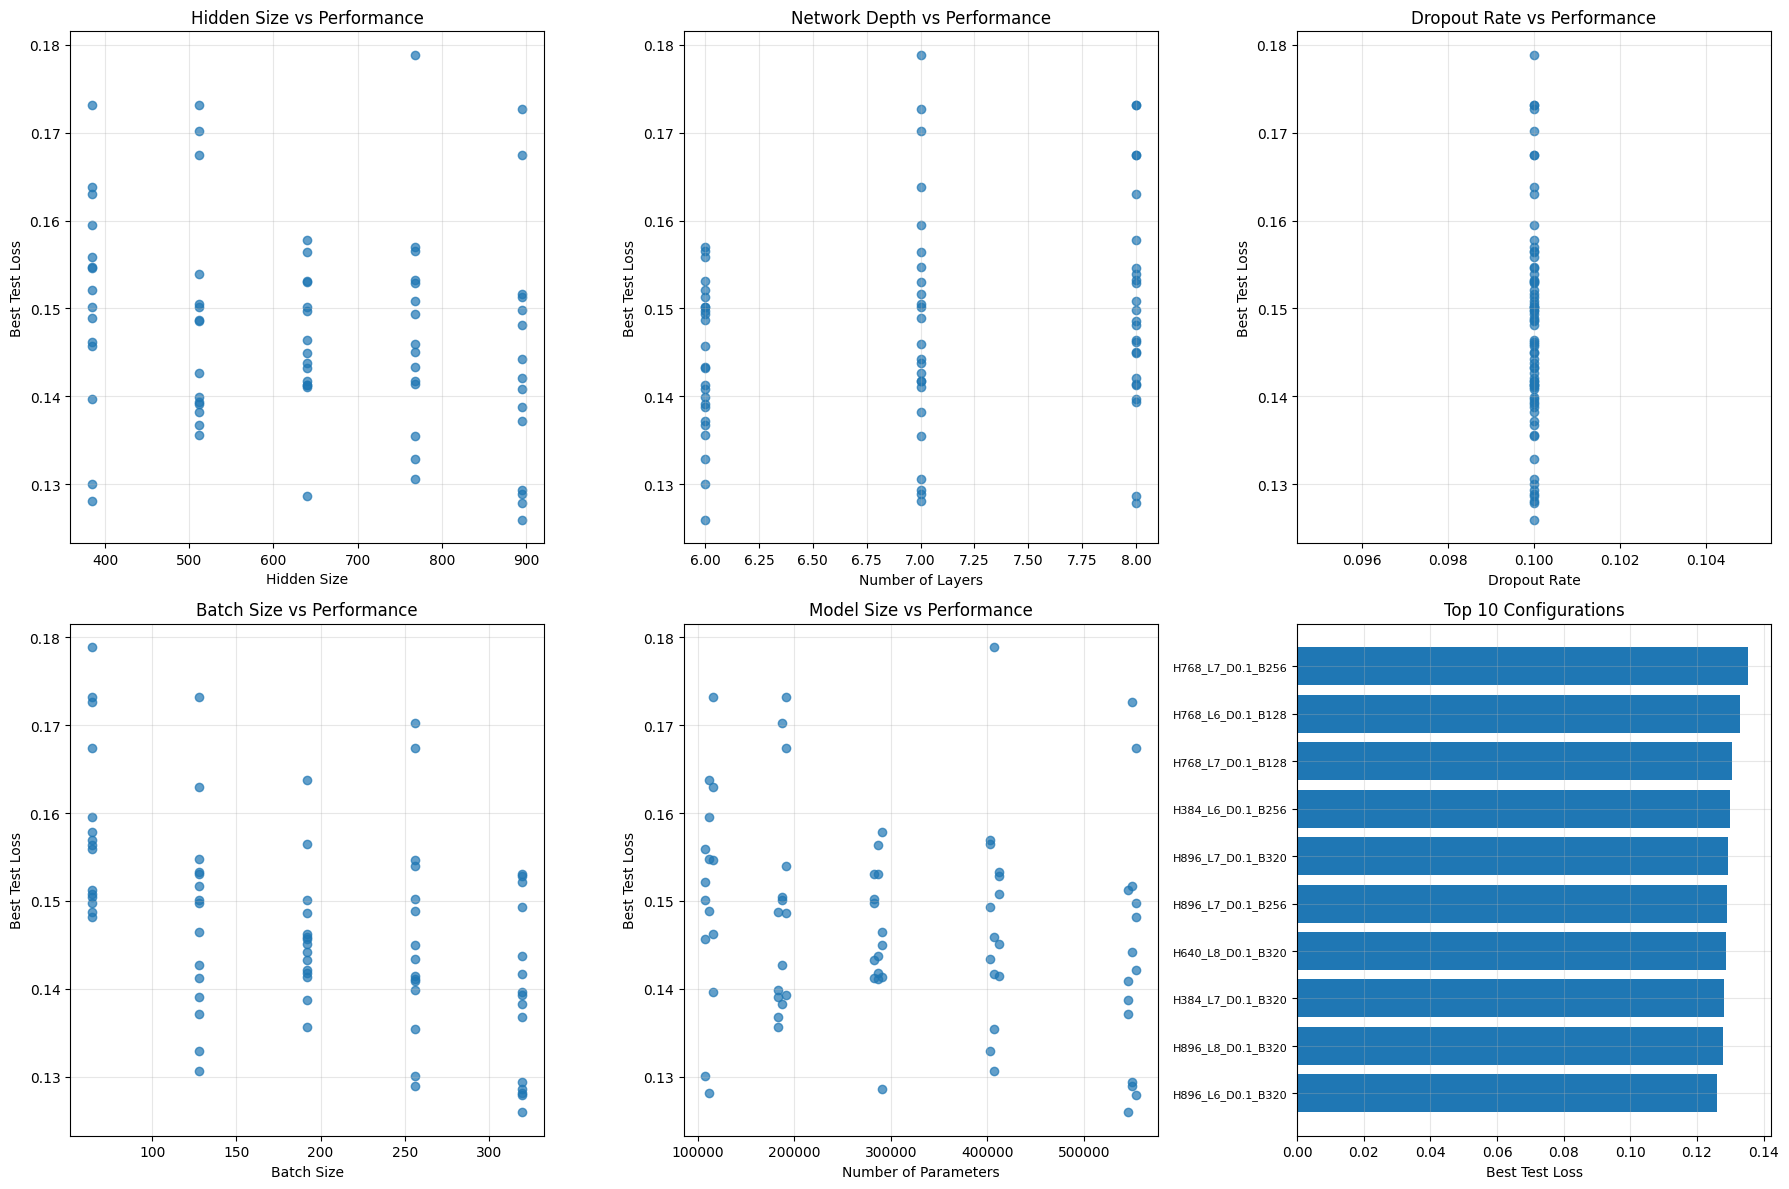


🏆 최고 성능 모델:
  Hidden Size: 896
  Num Layers: 6
  Dropout: 0.1
  Batch Size: 320
  Best Test Loss: 0.125927
  Parameters: 545,274

그리드 서치 완료! 모든 결과가 저장되었습니다. 🎯


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import time
from datetime import datetime
import itertools

class PolynomialDataset(Dataset):
    def __init__(self, data_file, train=True, train_ratio=0.8, normalize=True):
        """
        저장된 데이터 파일로부터 Dataset 생성
        
        Args:
            data_file: 데이터 파일 경로 (.json 또는 .pkl)
            train: True면 훈련용, False면 테스트용
            train_ratio: 훈련/테스트 분할 비율
            normalize: 데이터 정규화 여부
        """
        self.data = self.load_data(data_file)
        self.normalize = normalize
        self.coeffs, self.roots = self.prepare_data()
        
        # 정규화 파라미터 저장
        if normalize:
            self.coeff_mean = np.mean(self.coeffs, axis=0)
            self.coeff_std = np.std(self.coeffs, axis=0) + 1e-8
            self.root_mean = np.mean(self.roots, axis=0)
            self.root_std = np.std(self.roots, axis=0) + 1e-8
            
            # 정규화 적용
            self.coeffs = (self.coeffs - self.coeff_mean) / self.coeff_std
            self.roots = (self.roots - self.root_mean) / self.root_std
        
        # 훈련/테스트 분할
        train_coeffs, test_coeffs, train_roots, test_roots = train_test_split(
            self.coeffs, self.roots, train_size=train_ratio, random_state=42
        )
        
        if train:
            self.coeffs = train_coeffs
            self.roots = train_roots
        else:
            self.coeffs = test_coeffs
            self.roots = test_roots
        
        print(f"{'훈련' if train else '테스트'} 데이터셋: {len(self.coeffs)}개")
        if normalize:
            print(f"데이터 정규화 적용됨")
    
    def load_data(self, filename):
        """데이터 파일 로드"""
        if filename.endswith('.json'):
            with open(filename, 'r', encoding='utf-8') as f:
                return json.load(f)
        elif filename.endswith('.pkl'):
            with open(filename, 'rb') as f:
                return pickle.load(f)
        else:
            raise ValueError("지원하지 않는 파일 형식입니다. (.json 또는 .pkl 사용)")
    
    def prepare_data(self):
        """데이터를 학습용 형태로 변환"""
        coeffs = []
        roots = []
        
        for item in self.data:
            coeffs.append(item['coefficients'])
            
            # 근 데이터 형식 확인 및 변환
            item_roots = item['roots']
            
            if isinstance(item_roots[0], list):
                # [[실수부, 허수부], ...] 형태를 [실수부1, 허수부1, ...] 형태로 평탄화
                flattened_roots = []
                for root in item_roots:
                    flattened_roots.extend(root)
                roots.append(flattened_roots)
            else:
                # 이미 [실수부1, 허수부1, ...] 형태
                roots.append(item_roots)
        
        return np.array(coeffs, dtype=np.float32), np.array(roots, dtype=np.float32)
    
    def denormalize_roots(self, normalized_roots):
        """근을 원래 스케일로 되돌리기"""
        if self.normalize and hasattr(self, 'root_mean'):
            return normalized_roots * self.root_std + self.root_mean
        return normalized_roots
    
    def __len__(self):
        return len(self.coeffs)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.coeffs[idx]), torch.FloatTensor(self.roots[idx])

class OptimizedPolynomialRootNet(nn.Module):
    """경량화된 효율적인 다항식 근 찾기 네트워크"""
    def __init__(self, input_size=6, output_size=10, hidden_size=512, num_layers=4, dropout=0.3):
        super(OptimizedPolynomialRootNet, self).__init__()
        
        layers = []
        current_size = input_size
        
        # 첫 번째 층
        layers.extend([
            nn.Linear(current_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(dropout)
        ])
        current_size = hidden_size
        
        # 중간 층들 (점진적 크기 감소)
        for i in range(num_layers - 2):
            next_size = hidden_size // (2 ** (i + 1))
            next_size = max(next_size, 64)  # 최소 64개 뉴런
            
            layers.extend([
                nn.Linear(current_size, next_size),
                nn.ReLU(),
                nn.BatchNorm1d(next_size),
                nn.Dropout(dropout * 0.8)  # 점진적으로 드롭아웃 감소
            ])
            current_size = next_size
        
        # 출력층
        layers.append(nn.Linear(current_size, output_size))
        
        self.network = nn.Sequential(*layers)
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.network(x)

class GridSearchTrainer:
    def __init__(self, data_file, device='cpu'):
        self.data_file = data_file
        self.device = device
        self.results = []
        
        # 데이터셋 한 번만 로드 (매번 새로 로드하면 시간 소요)
        print("데이터셋 로딩 중...")
        self.train_dataset = PolynomialDataset(data_file, train=True, normalize=True)
        self.test_dataset = PolynomialDataset(data_file, train=False, normalize=True)
        
    def complex_aware_loss(self, pred_roots, true_roots, alpha=0.3):
        """복소수 근을 고려한 손실 함수"""
        mse_loss = nn.MSELoss()(pred_roots, true_roots)
        
        pred_real = pred_roots[:, 0::2]
        pred_imag = pred_roots[:, 1::2]
        true_real = true_roots[:, 0::2]
        true_imag = true_roots[:, 1::2]
        
        pred_magnitude = torch.sqrt(pred_real**2 + pred_imag**2)
        true_magnitude = torch.sqrt(true_real**2 + true_imag**2)
        magnitude_loss = nn.MSELoss()(pred_magnitude, true_magnitude)
        
        return (1 - alpha) * mse_loss + alpha * magnitude_loss
    
    def train_single_config(self, hidden_size, num_layers, dropout, batch_size, epochs=80, lr=0.008):
        """단일 구성으로 모델 훈련"""
        
        # 데이터 로더 생성
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # 모델 생성
        model = OptimizedPolynomialRootNet(
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(self.device)
        
        param_count = sum(p.numel() for p in model.parameters())
        
        # 옵티마이저 및 스케줄러
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10
        )
        
        # 훈련 기록
        train_losses = []
        test_losses = []
        best_test_loss = float('inf')
        
        # 훈련 루프
        for epoch in range(epochs):
            # 훈련
            model.train()
            train_loss = 0
            for coeffs, roots in train_loader:
                coeffs, roots = coeffs.to(self.device), roots.to(self.device)
                
                optimizer.zero_grad()
                pred_roots = model(coeffs)
                loss = self.complex_aware_loss(pred_roots, roots)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            
            # 테스트
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for coeffs, roots in test_loader:
                    coeffs, roots = coeffs.to(self.device), roots.to(self.device)
                    pred_roots = model(coeffs)
                    loss = self.complex_aware_loss(pred_roots, roots)
                    test_loss += loss.item()
            
            test_loss /= len(test_loader)
            test_losses.append(test_loss)
            
            scheduler.step(test_loss)
            
            if test_loss < best_test_loss:
                best_test_loss = test_loss
        
        return {
            'model': model,
            'param_count': param_count,
            'best_test_loss': best_test_loss,
            'final_train_loss': train_losses[-1],
            'train_losses': train_losses,
            'test_losses': test_losses
        }
    
    def grid_search(self, config_ranges, epochs=80, lr=0.008):
        """그리드 서치 실행"""
        
        # 모든 조합 생성
        combinations = list(itertools.product(
            config_ranges['hidden_size'],
            config_ranges['num_layers'],
            config_ranges['dropout'],
            config_ranges['batch_size']
        ))
        
        total_combinations = len(combinations)
        print(f"총 {total_combinations}개의 조합을 테스트합니다.")
        print("=" * 80)
        
        start_time = time.time()
        
        for i, (hidden_size, num_layers, dropout, batch_size) in enumerate(combinations):
            print(f"\n[{i+1}/{total_combinations}] 테스트 중...")
            print(f"Hidden Size: {hidden_size}, Layers: {num_layers}, Dropout: {dropout}, Batch Size: {batch_size}")
            
            config_start_time = time.time()
            
            try:
                result = self.train_single_config(
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    dropout=dropout,
                    batch_size=batch_size,
                    epochs=epochs,
                    lr=lr
                )
                
                config_time = time.time() - config_start_time
                
                # 결과 저장
                config_result = {
                    'config_id': i + 1,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'dropout': dropout,
                    'batch_size': batch_size,
                    'param_count': result['param_count'],
                    'best_test_loss': result['best_test_loss'],
                    'final_train_loss': result['final_train_loss'],
                    'training_time': config_time,
                    'model_state_dict': result['model'].state_dict(),
                    'train_losses': result['train_losses'],
                    'test_losses': result['test_losses']
                }
                
                self.results.append(config_result)
                
                # 모델 저장
                model_filename = f"model_h{hidden_size}_l{num_layers}_d{dropout:.1f}_b{batch_size}.pth"
                torch.save({
                    'model_state_dict': result['model'].state_dict(),
                    'config': config_result,
                    'model_architecture': {
                        'hidden_size': hidden_size,
                        'num_layers': num_layers,
                        'dropout': dropout
                    }
                }, model_filename)
                
                print(f"✓ 완료 - Test Loss: {result['best_test_loss']:.6f}, 시간: {config_time:.1f}초")
                print(f"  모델 저장: {model_filename}")
                
            except Exception as e:
                print(f"✗ 오류 발생: {str(e)}")
                continue
            
            # 진행률 및 예상 시간
            elapsed_time = time.time() - start_time
            avg_time_per_config = elapsed_time / (i + 1)
            remaining_configs = total_combinations - (i + 1)
            estimated_remaining_time = avg_time_per_config * remaining_configs
            
            print(f"진행률: {(i+1)/total_combinations*100:.1f}% | "
                  f"예상 남은 시간: {estimated_remaining_time/60:.1f}분")
        
        total_time = time.time() - start_time
        print(f"\n그리드 서치 완료! 총 시간: {total_time/3600:.2f}시간")
        
        return self.results
    
    def save_results_table(self, filename="grid_search_results.csv"):
        """결과를 CSV 테이블로 저장"""
        if not self.results:
            print("저장할 결과가 없습니다.")
            return
        
        # DataFrame 생성용 데이터
        table_data = []
        for result in self.results:
            table_data.append({
                'Config_ID': result['config_id'],
                'Hidden_Size': result['hidden_size'],
                'Num_Layers': result['num_layers'],
                'Dropout': result['dropout'],
                'Batch_Size': result['batch_size'],
                'Parameters': result['param_count'],
                'Best_Test_Loss': result['best_test_loss'],
                'Final_Train_Loss': result['final_train_loss'],
                'Overfitting_Gap': result['final_train_loss'] - result['best_test_loss'],
                'Training_Time_Min': result['training_time'] / 60
            })
        
        df = pd.DataFrame(table_data)
        
        # 성능 순으로 정렬
        df = df.sort_values('Best_Test_Loss')
        df = df.reset_index(drop=True)
        df['Rank'] = range(1, len(df) + 1)
        
        # CSV 저장
        df.to_csv(filename, index=False)
        print(f"결과 테이블 저장: {filename}")
        
        # 상위 10개 결과 출력
        print("\n=== 상위 10개 결과 ===")
        print(df.head(10).to_string(index=False))
        
        return df
    
    def plot_results_analysis(self):
        """결과 분석 시각화"""
        if not self.results:
            print("분석할 결과가 없습니다.")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 데이터 준비
        hidden_sizes = [r['hidden_size'] for r in self.results]
        num_layers = [r['num_layers'] for r in self.results]
        dropouts = [r['dropout'] for r in self.results]
        batch_sizes = [r['batch_size'] for r in self.results]
        test_losses = [r['best_test_loss'] for r in self.results]
        param_counts = [r['param_count'] for r in self.results]
        
        # 1. Hidden Size vs Test Loss
        axes[0,0].scatter(hidden_sizes, test_losses, alpha=0.7)
        axes[0,0].set_xlabel('Hidden Size')
        axes[0,0].set_ylabel('Best Test Loss')
        axes[0,0].set_title('Hidden Size vs Performance')
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Num Layers vs Test Loss
        axes[0,1].scatter(num_layers, test_losses, alpha=0.7)
        axes[0,1].set_xlabel('Number of Layers')
        axes[0,1].set_ylabel('Best Test Loss')
        axes[0,1].set_title('Network Depth vs Performance')
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Dropout vs Test Loss
        axes[0,2].scatter(dropouts, test_losses, alpha=0.7)
        axes[0,2].set_xlabel('Dropout Rate')
        axes[0,2].set_ylabel('Best Test Loss')
        axes[0,2].set_title('Dropout Rate vs Performance')
        axes[0,2].grid(True, alpha=0.3)
        
        # 4. Batch Size vs Test Loss
        axes[1,0].scatter(batch_sizes, test_losses, alpha=0.7)
        axes[1,0].set_xlabel('Batch Size')
        axes[1,0].set_ylabel('Best Test Loss')
        axes[1,0].set_title('Batch Size vs Performance')
        axes[1,0].grid(True, alpha=0.3)
        
        # 5. Parameters vs Test Loss
        axes[1,1].scatter(param_counts, test_losses, alpha=0.7)
        axes[1,1].set_xlabel('Number of Parameters')
        axes[1,1].set_ylabel('Best Test Loss')
        axes[1,1].set_title('Model Size vs Performance')
        axes[1,1].grid(True, alpha=0.3)
        
        # 6. Best configurations 히트맵
        best_configs = sorted(self.results, key=lambda x: x['best_test_loss'])[:10]
        config_names = [f"H{c['hidden_size']}_L{c['num_layers']}_D{c['dropout']:.1f}_B{c['batch_size']}" 
                       for c in best_configs]
        losses = [c['best_test_loss'] for c in best_configs]
        
        axes[1,2].barh(range(len(config_names)), losses)
        axes[1,2].set_yticks(range(len(config_names)))
        axes[1,2].set_yticklabels(config_names, fontsize=8)
        axes[1,2].set_xlabel('Best Test Loss')
        axes[1,2].set_title('Top 10 Configurations')
        axes[1,2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('grid_search_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
def main():
    # 설정
    data_file = "polynomial_dataset_sorted.json"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"사용 디바이스: {device}")
    
    if not os.path.exists(data_file):
        print(f"데이터 파일을 찾을 수 없습니다: {data_file}")
        return
    
    # 그리드 서치 범위 정의
    # 128*4, 128*5, 128*6, 128*7, 128*8, 128*9, 128*10, 128*11, 128*12
    config_ranges = {
        'hidden_size': [128*3, 128*4, 128*5, 128*6, 128*7],
        'num_layers': [6, 7, 8],
        'dropout': [0.1],
        'batch_size': [64, 128, 64*3, 64*4, 64*5]
    }
    
    print("그리드 서치 범위:")
    for key, values in config_ranges.items():
        print(f"  {key}: {values}")
    
    total_combinations = 1
    for values in config_ranges.values():
        total_combinations *= len(values)
    print(f"총 조합 수: {total_combinations}")
    
    # 그리드 서치 실행
    trainer = GridSearchTrainer(data_file, device)
    results = trainer.grid_search(config_ranges, epochs=80, lr=0.008)
    
    # 결과 저장 및 분석
    results_df = trainer.save_results_table("polynomial_grid_search_results.csv")
    trainer.plot_results_analysis()
    
    # 최고 성능 모델 정보
    if results:
        best_result = min(results, key=lambda x: x['best_test_loss'])
        print(f"\n🏆 최고 성능 모델:")
        print(f"  Hidden Size: {best_result['hidden_size']}")
        print(f"  Num Layers: {best_result['num_layers']}")
        print(f"  Dropout: {best_result['dropout']}")
        print(f"  Batch Size: {best_result['batch_size']}")
        print(f"  Best Test Loss: {best_result['best_test_loss']:.6f}")
        print(f"  Parameters: {best_result['param_count']:,}")
    
    print("\n그리드 서치 완료! 모든 결과가 저장되었습니다. 🎯")

if __name__ == "__main__":
    main()